In [4]:
# detect chapter starts from the expanded epub
# here, just take the raw text and turn it into sentences
from os import listdir
from os.path import isfile, join
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from json import loads
from re import findall,UNICODE
from labMTsimple.labMTsimple.speedy import LabMT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [5]:
isbn = 9780618574940

In [6]:
fname = "data/kindle/{0}.txt".format(isbn)
def load_chunks(fname):
    f = open(fname,"r")
    raw_text = f.read()
    f.close()
    lines = raw_text.split("\n")
    raw_text_clean = re.sub("\n[\\s\n]+?\n","\n\n",raw_text)
    chunks = re.split("\n\n\n*",raw_text_clean)
    return chunks
chunks = load_chunks(fname)

In [10]:
def replace_honorifics(s):
    honorifics = ["Mr","Master","Miss","Ms","Mrs","Mx",
              "Sir","Madame","Dame","Lord","Lady","Esq","Adv",
              "Dr","Prof",
              "Rev","Fr","Pr","Br","Sr","Elder","Rabbo"]
    abbreviations = ["J.R.R"] # ,"Ph.D","M.S"] # <- could end a sentence...
    for h in honorifics+abbreviations:
        s = re.sub(h+"\\.",h,s)
    return s
sentence_re = re.compile('[\\s\n]*(.+?[\\.!?]+["’]*(?=\\s+[A-Z"’‘]|$))',flags=re.DOTALL)
def find_sentences(s):
    return sentence_re.findall(replace_honorifics(s))
sentences = []
for c_str in chunks:
    sentences.extend(find_sentences(c_str))

In [11]:
sentences[:10]

['In the Land of Mordor where the Shadows lie.',
 'In the Land of Mordor where the Shadows lie.',
 'J.R.R Tolkien’s The Lord of the Rings is often erroneously called a trilogy, when it is in fact a single novel, consisting of six books plus appendices, sometimes published in three volumes.',
 'The first volume, The Fellowship of the Ring, was published in Great Britain by the London firm George Allen & Unwin on 29 July 1954; an American edition followed on 21 October of the same year, published by Houghton Mifflin Company of Boston.',
 'In the production of this first volume, Tolkien experienced what became for him a continual problem: printer’s errors and compositor’s mistakes, including well-intentioned ‘corrections’ of his sometimes idiosyncratic usage.',
 'These ‘corrections’ include the altering of dwarves to dwarfs, elvish to elfish, further to farther, nasturtians to nasturtiums, try and say to try to say and (‘worst of all’ to Tolkien) elven to elfin.',
 'In a work such as The 

In [8]:
# now, let's google simple phrase model
# remove all periods from the end of sentences
# and remove all quotations that start or end words
# shit, we're tokenizing
# remove all case as well

In [25]:
def strip_sentence_grammar(s):
    if s[-1] == ".":
        s = s[:-1]
    s = s.lower()
    # s = s.replace("’s","")
    s = s.replace(",","")
    return s
sentences_stripped = list(map(strip_sentence_grammar,sentences))

In [26]:
sentences_stripped[:10]

['in the land of mordor where the shadows lie',
 'in the land of mordor where the shadows lie',
 'j.r.r tolkien’s the lord of the rings is often erroneously called a trilogy when it is in fact a single novel consisting of six books plus appendices sometimes published in three volumes',
 'the first volume the fellowship of the ring was published in great britain by the london firm george allen & unwin on 29 july 1954; an american edition followed on 21 october of the same year published by houghton mifflin company of boston',
 'in the production of this first volume tolkien experienced what became for him a continual problem: printer’s errors and compositor’s mistakes including well-intentioned ‘corrections’ of his sometimes idiosyncratic usage',
 'these ‘corrections’ include the altering of dwarves to dwarfs elvish to elfish further to farther nasturtians to nasturtiums try and say to try to say and (‘worst of all’ to tolkien) elven to elfin',
 'in a work such as the lord of the rings 

In [27]:
sentences_split = list(map(lambda x: x.split(" "),sentences_stripped))
print(sentences_split[:10])

[['in', 'the', 'land', 'of', 'mordor', 'where', 'the', 'shadows', 'lie'], ['in', 'the', 'land', 'of', 'mordor', 'where', 'the', 'shadows', 'lie'], ['j.r.r', 'tolkien’s', 'the', 'lord', 'of', 'the', 'rings', 'is', 'often', 'erroneously', 'called', 'a', 'trilogy', 'when', 'it', 'is', 'in', 'fact', 'a', 'single', 'novel', 'consisting', 'of', 'six', 'books', 'plus', 'appendices', 'sometimes', 'published', 'in', 'three', 'volumes'], ['the', 'first', 'volume', 'the', 'fellowship', 'of', 'the', 'ring', 'was', 'published', 'in', 'great', 'britain', 'by', 'the', 'london', 'firm', 'george', 'allen', '&', 'unwin', 'on', '29', 'july', '1954;', 'an', 'american', 'edition', 'followed', 'on', '21', 'october', 'of', 'the', 'same', 'year', 'published', 'by', 'houghton', 'mifflin', 'company', 'of', 'boston'], ['in', 'the', 'production', 'of', 'this', 'first', 'volume', 'tolkien', 'experienced', 'what', 'became', 'for', 'him', 'a', 'continual', 'problem:', 'printer’s', 'errors', 'and', 'compositor’s', 'm

In [28]:
unigrams = dict()
bigrams = dict()
for s in sentences_split:
    for word in s:
        if word in unigrams:
            unigrams[word] += 1
        else:
            unigrams[word] = 1
    for i in range(len(s)-1):
        bg = " ".join(s[i:i+2])
        # bg = " ".join([s[i],s[i+1]])
        if bg in bigrams:
            bigrams[bg] += 1
        else:
            bigrams[bg] = 1

In [29]:
unigrams["frodo"]

944

In [30]:
bigrams["minas tirith"]

25

In [31]:
print(len(unigrams))
print(len(bigrams))

13853
79693


In [32]:
threshold = .0005
# min number of times it has to show up
delta = 5

In [33]:
# phrases = []
# for wordi in unigrams:
#     for wordj in unigrams:
#         if not wordi == wordj:
#             bg = " ".join([wordi,wordj])
#             if bg in bigrams:
#                 score = (bigrams[bg]-delta)/(unigrams[wordi]*unigrams[wordj])
#                 if score > threshold:
#                     phrases.append(bg)
#                     print(bg)
phrases = []
for bg in bigrams:
    wordi,wordj = bg.split(" ")
    score = (bigrams[bg]-delta)/(unigrams[wordi]*unigrams[wordj])
    if score > threshold:
        phrases.append(bg)
        # print(bg)

In [34]:
phrases

['red book',
 'never seen',
 'any case',
 'world outside',
 'mr baggins',
 'sarn gebir',
 'poor old',
 'their minds',
 'gladden fields',
 'black figures',
 'good deal',
 'these parts',
 'an effort',
 'years ago',
 'minas tirith',
 'at least',
 'fatty bolger',
 '‘i am',
 'farmer maggot',
 'christopher tolkien',
 '‘ “i',
 'don’t know',
 'mr underhill',
 'emyn muil',
 'michel delving',
 '‘let us',
 'rather than',
 'lady galadriel',
 'an hour',
 '& unwin',
 'elder days',
 'at length',
 'fell asleep',
 'nothing else',
 'any rate',
 'long ago',
 'allen &',
 'either side',
 'something else',
 'fast asleep',
 'those who',
 'third age',
 'no longer',
 'their backs',
 'brandywine bridge',
 'dark tower',
 'bag end',
 'worry about',
 '‘of course',
 'am afraid',
 'mr butterbur',
 'gandalf ’s',
 'redhorn gate',
 'amon hen',
 'let us',
 'next day',
 'their heads',
 'doom doom',
 'houghton mifflin',
 'sam gamgee',
 'low voice',
 'picked up',
 'tol brandir',
 'your pardon',
 'turned aside',
 'worse tha

In [35]:
for j,s in enumerate(sentences_split):
    joins = []
    for i in range(len(s)-1):
        bg = " ".join(s[i:i+2])
        if bg in phrases:
            joins.append(i+1)
    new_s = [s[0]]
    for i in range(1,len(s)-1):
        if i in joins:
            new_s[-1] = " ".join([new_s[-1],s[i]])
        else:
            new_s.append(s[i])
    sentences_split[j] = new_s


In [36]:
unigrams = dict()
bigrams = dict()
for s in sentences_split:
    for word in s:
        if word in unigrams:
            unigrams[word] += 1
        else:
            unigrams[word] = 1
    for i in range(len(s)-1):
        bg = " ".join(s[i:i+2])
        # bg = " ".join([s[i],s[i+1]])
        if bg in bigrams:
            bigrams[bg][0] += 1
        else:
            bigrams[bg] = [1,s[i:i+2]]

In [37]:
threshold = .00005
phrases = []
for bg in bigrams:
    wordi,wordj = bigrams[bg][1]
    score = (bigrams[bg][0]-delta)/(unigrams[wordi]*unigrams[wordj])
    if score > threshold:
        phrases.append(bg)

In [38]:
for p in phrases:
    if len(p.split(" "))>2:
        print(p)

at any rate
in any case
had never seen
at bag end
no sign of
i don’t know
the misty mountains
i am afraid
‘i don’t know
on either side
don’t know what
‘i don’t know’
have never seen
a good deal


In [39]:
len(bigrams)

73995

In [40]:
for j,s in enumerate(sentences_split):
    joins = []
    for i in range(len(s)-1):
        bg = " ".join(s[i:i+2])
        if bg in phrases:
            joins.append(i+1)
    new_s = [s[0]]
    for i in range(1,len(s)-1):
        if i in joins:
            new_s[-1] = " ".join([new_s[-1],s[i]])
        else:
            new_s.append(s[i])
    sentences_split[j] = new_s
unigrams = dict()
bigrams = dict()
for s in sentences_split:
    for word in s:
        if word in unigrams:
            unigrams[word] += 1
        else:
            unigrams[word] = 1
    for i in range(len(s)-1):
        bg = " ".join(s[i:i+2])
        # bg = " ".join([s[i],s[i+1]])
        if bg in bigrams:
            bigrams[bg][0] += 1
        else:
            bigrams[bg] = [1,s[i:i+2]]
threshold = .00005
phrases = []
for bg in bigrams:
    wordi,wordj = bigrams[bg][1]
    score = (bigrams[bg][0]-delta)/(unigrams[wordi]*unigrams[wordj])
    if score > threshold:
        phrases.append(bg)
for j,s in enumerate(sentences_split):
    joins = []
    for i in range(len(s)-1):
        bg = " ".join(s[i:i+2])
        if bg in phrases:
            joins.append(i+1)
    new_s = [s[0]]
    for i in range(1,len(s)-1):
        if i in joins:
            new_s[-1] = " ".join([new_s[-1],s[i]])
        else:
            new_s.append(s[i])
    sentences_split[j] = new_s

In [41]:
bigrams = dict()
trigrams = dict()
fourgrams = dict()
for u in unigrams:
    if len(u.split(" "))==2:
        bigrams[u] = unigrams[u]
    if len(u.split(" "))==3:
        trigrams[u] = unigrams[u]
    if len(u.split(" "))==4:
        fourgrams[u] = unigrams[u]

In [42]:
len(bigrams)

788

In [43]:
len(trigrams)

581

In [44]:
len(fourgrams)

142

In [45]:
a = [(f,fourgrams[f]) for f in fourgrams]
a.sort(key=lambda x: x[1],reverse=True)
print(a[:20])

[('if you want to', 7), ('i do not know', 7), ('i will tell you', 6), ('i have never seen', 6), ('‘i don’t know what', 6), ('i don’t know what', 5), ('‘i do not know’', 5), ('‘i do not know', 5), ('there is no time', 5), ('i have never heard', 4), ('he had never seen', 4), ('it is no good', 4), ('he had never heard', 4), ('i should like a', 4), ('it would have been', 3), ('if you know what', 3), ('when they had eaten', 3), ('‘but i am not', 3), ('it seemed to be', 3), ('they came out of', 3)]


In [46]:
sorted(fourgrams,reverse=True,key=lambda x: fourgrams[x])[:30]

['if you want to',
 'i do not know',
 'i will tell you',
 'i have never seen',
 '‘i don’t know what',
 'i don’t know what',
 '‘i do not know’',
 '‘i do not know',
 'there is no time',
 'i have never heard',
 'he had never seen',
 'it is no good',
 'he had never heard',
 'i should like a',
 'it would have been',
 'if you know what',
 'when they had eaten',
 '‘but i am not',
 'it seemed to be',
 'they came out of',
 'what do you think',
 'i am going to',
 'we will not speak',
 '‘it is no good',
 'it might have been',
 'i have never been',
 'there is no other',
 '‘and i do not',
 '– if you can',
 '‘what do you think']

In [47]:
sorted(trigrams,reverse=True,key=lambda x: trigrams[x])[:30]

['seemed to be',
 'the lord of',
 'as soon as',
 'it seemed to',
 'the edge of',
 'i do not',
 'as far as',
 'the top of',
 'it would be',
 'he could not',
 'the middle of',
 'no sign of',
 'at any rate',
 'as well as',
 'could be seen',
 'the misty mountains',
 'he had been',
 'the sun was',
 '‘i do not',
 'they could see',
 'a good deal',
 'there is no',
 'in any case',
 'the midst of',
 'i am not',
 'they could not',
 'they had been',
 '‘what do you',
 'on either side',
 'the bottom of']

In [48]:
sorted(bigrams,reverse=True,key=lambda x: bigrams[x])[:30]

['it was',
 'there was',
 'it is',
 'they were',
 'out of',
 'the ring',
 'he had',
 'as if',
 'did not',
 'they had',
 'the road',
 'the shire',
 'i have',
 'had been',
 'to be',
 'like a',
 'there were',
 'at last',
 'a great',
 'the company',
 'there is',
 'began to',
 'if you',
 'seemed to',
 'i am',
 'do not',
 'end of',
 'they are',
 'there are',
 'the others']

In [49]:
sorted(unigrams,reverse=True,key=lambda x: unigrams[x])[:20]

['the',
 'and',
 'of',
 'in',
 'a',
 'to',
 'that',
 'he',
 'was',
 'but',
 'it',
 'for',
 'i',
 'on',
 'they',
 'as',
 'with',
 'his',
 'you',
 'all']

In [50]:
def google_partition(sentences,niter=4
                     
                     ,thresholds=[.001,.0001,.00005,.00001]):
    def strip_sentence_grammar(s):
        if s[-1] == ".":
            s = s[:-1]
        s = s.lower()
        # s = s.replace("’s","")
        s = s.replace(",","")
        return s
    sentences_stripped = list(map(strip_sentence_grammar,sentences))
    sentences_split = list(map(lambda x: x.split(" "),sentences_stripped))
    # print(sentences_split[:10])
    
    delta = 5
    
    for k in range(niter):
        threshold = thresholds[k]
        unigrams = dict()
        bigrams = dict()
        for s in sentences_split:
            for word in s:
                if word in unigrams:
                    unigrams[word] += 1
                else:
                    unigrams[word] = 1
            for i in range(len(s)-1):
                bg = " ".join(s[i:i+2])
                # bg = " ".join([s[i],s[i+1]])
                if bg in bigrams:
                    bigrams[bg][0] += 1
                else:
                    bigrams[bg] = [1,s[i:i+2]]
        phrases = []
        for bg in bigrams:
            wordi,wordj = bigrams[bg][1]
            score = (bigrams[bg][0]-delta)/(unigrams[wordi]*unigrams[wordj])
            if score > threshold:
                phrases.append(bg)
        for j,s in enumerate(sentences_split):
            joins = []
            for i in range(len(s)-1):
                bg = " ".join(s[i:i+2])
                if bg in phrases:
                    joins.append(i+1)
            new_s = [s[0]]
            for i in range(1,len(s)-1):
                if i in joins:
                    new_s[-1] = " ".join([new_s[-1],s[i]])
                else:
                    new_s.append(s[i])
            sentences_split[j] = new_s
#     bigrams = dict()
#     trigrams = dict()
#     fourgrams = dict()
#     unigrams = dict()
    grams = [dict() for i in range(2**niter)]
    for s in sentences_split:
        for word in s:
            nwords = len(word.split(" "))-1
            if word in grams[nwords]:
                grams[nwords][word] += 1
            else:
                grams[nwords][word] = 1
    # return (unigrams,bigrams,trigrams,fourgrams)
    return grams,sentences_split

In [51]:
grams,partitioned_sentences = google_partition(sentences)

In [52]:
print([len(g) for g in grams])
for k in range(len(grams)):
    if len(grams[k]) > 0:
        print(k+1,sorted(grams[k],reverse=True,key=lambda x: grams[k][x])[:10])

[10634, 1754, 2075, 701, 168, 67, 15, 3, 2, 0, 0, 0, 0, 0, 0, 0]
1 ['and', 'the', 'of', 'but', 'that', 'a', 'to', 'in', 'it', 'was']
2 ['in the', 'of the', 'it was', 'on the', 'it is', 'they were', 'he was', 'with a', 'to the', 'the ring']
3 ['there was a', 'for a while', 'for a moment', 'as soon as', 'it seemed to', 'seemed to be', 'in the shire', 'one of the', 'he did not', '‘i do not']
4 ['in the midst of', 'as if he was', 'at the end of', 'the other side of', 'in the middle of', 'if you want to', 'there seemed to be', 'a matter of fact', 'he added with a', 'but it was not']
5 ['the lord of the rings', 'it seemed to him that', 'at the bottom of the', 'in the house of elrond', 'the ring in his hand', 'as far as they could', 'he found that he was', 'then he got up and', 'slopes of the hill and', 'out of the west and']
6 ['of the lord of the rings', 'of the fellowship of the ring', 'at the end of the long', 'to the top of the bank', 'for the history of the war', 'of the master of the h

In [53]:
def serial_partition(sentences):
    print(len(sentences))
    clauses = []
    for s in sentences:
        clauses.extend(re.split(r"[,;()?–]+",s))
    print(len(clauses))
    print(clauses[:10])
    clauses_split = list(map(lambda x: re.findall(r"([\w&]+[]*[\w&]+)",x,flags=re.IGNORECASE),clauses))
    print(clauses_split[0])
    longest_clause = sorted(clauses_split,reverse=True,key=lambda x: len(x))
    print(len(longest_clause[0]))
    print(longest_clause[0])
    
    def context_model():
        pass
    
    return 1

In [54]:
serial_partition(sentences)

12645
26825
['In the Land of Mordor where the Shadows lie.', 'In the Land of Mordor where the Shadows lie.', 'J.R.R Tolkien’s The Lord of the Rings is often erroneously called a trilogy', ' when it is in fact a single novel', ' consisting of six books plus appendices', ' sometimes published in three volumes.', 'The first volume', ' The Fellowship of the Ring', ' was published in Great Britain by the London firm George Allen & Unwin on 29 July 1954', ' an American edition followed on 21 October of the same year']
['In', 'the', 'Land', 'of', 'Mordor', 'where', 'the', 'Shadows', 'lie']
39
['At', 'the', 'end', 'of', 'the', 'Third', 'Age', 'the', 'part', 'played', 'by', 'the', 'Hobbits', 'in', 'the', 'great', 'events', 'that', 'led', 'to', 'the', 'inclusion', 'of', 'the', 'Shire', 'in', 'the', 'Reunited', 'Kingdom', 'awakened', 'among', 'them', 'more', 'widespread', 'interest', 'in', 'their', 'own', 'history']


1

let's look for the happy/not happy...

In [55]:
"happy" in grams[0]

True

In [56]:
[x for x in grams[1] if "happy" in x]

[]

"not happy" didn't exist...

### now we have the rough phrase partition, let's do an embedding with a smoothed context window

In [57]:
# since I don't care about context any more than bag of words...
sentences_split[:10]

[['in', 'the land', 'of mordor where'],
 ['in', 'the land', 'of mordor where'],
 ['j.r.r',
  'tolkien’s',
  'the lord of the rings',
  'is',
  'often',
  'erroneously',
  'called',
  'a',
  'trilogy',
  'when',
  'it is',
  'in fact',
  'a single',
  'novel',
  'consisting',
  'of',
  'six',
  'books',
  'plus',
  'appendices',
  'sometimes',
  'published'],
 ['the',
  'first',
  'volume',
  'the',
  'fellowship of the ring',
  'was',
  'published',
  'in',
  'great',
  'britain',
  'by',
  'the',
  'london',
  'firm',
  'george',
  'allen & unwin',
  'on',
  '29',
  'july',
  '1954;',
  'an',
  'american',
  'edition',
  'followed',
  'on',
  '21',
  'october',
  'of',
  'the same',
  'year',
  'published',
  'by',
  'houghton mifflin'],
 ['in',
  'the',
  'production',
  'of',
  'this',
  'first',
  'volume',
  'tolkien',
  'experienced',
  'what',
  'became',
  'for',
  'him',
  'a',
  'continual',
  'problem:',
  'printer’s',
  'errors',
  'and',
  'compositor’s',
  'mistakes',
  '

In [58]:
all_words = []
for x in partitioned_sentences:
    all_words.extend(x)

In [59]:
all_words[:50]

['in the land of',
 'in the land of',
 'j.r.r',
 'tolkien’s',
 'the lord of the rings',
 'is',
 'often',
 'erroneously',
 'called',
 'a',
 'trilogy',
 'when',
 'it is',
 'in fact',
 'a single',
 'novel',
 'consisting',
 'of',
 'six',
 'books',
 'plus',
 'appendices',
 'sometimes',
 'the first',
 'volume',
 'the fellowship of the ring was',
 'published in',
 'great',
 'britain',
 'by the',
 'london',
 'firm',
 'george',
 'allen & unwin',
 'on',
 '29',
 'july',
 '1954;',
 'an',
 'american',
 'edition',
 'followed',
 'on',
 '21',
 'october',
 'of',
 'the same',
 'year',
 'published',
 'by']

In [60]:
len(all_words)

102196

In [61]:
L = 5
from tqdm import tqdm

In [62]:
all_context_counts = dict()
all_phrase_counts = dict()
for word in all_words:
    if word not in all_context_counts:
        all_context_counts[word] = dict()
    if word not in all_phrase_counts:
        all_phrase_counts[word] = 1
    else:
        all_phrase_counts[word] += 1

In [63]:
len(all_context_counts)

15419

In [64]:
all_words_extended = all_words[:L]+all_words

In [65]:
for i in tqdm(range(L,len(all_words_extended))):
    context = all_words_extended[i-L:i+L+1]
    if not len(context) == L*2+1:
        print(i,len(context))
    w = all_words_extended[i]
    for c in context:
        if not c == w:
            if c not in all_context_counts[w]:
                all_context_counts[w][c] = 1
            else:
                all_context_counts[w][c] += 1

100%|██████████| 102196/102196 [00:00<00:00, 109197.29it/s]

102196 10
102197 9
102198 8
102199 7
102200 6


In [66]:
sorted([(key,all_context_counts["frodo"][key]) for key in all_context_counts["frodo"]],reverse=True,key=lambda x: x[1])[:30]

[('and', 112),
 ('the', 69),
 ('but', 32),
 ('of', 30),
 ('his', 29),
 ('a', 28),
 ('it', 24),
 ('that', 23),
 ('for', 20),
 ('he', 20),
 ('in', 19),
 ('was', 17),
 ('to', 16),
 ('now', 14),
 ('suddenly', 13),
 ('with', 13),
 ('over', 13),
 ('all', 12),
 ('on', 12),
 ('said', 12),
 ('or', 12),
 ('still', 12),
 ('it was', 11),
 ('him', 11),
 ('sam', 11),
 ('you', 11),
 ('no', 10),
 ('‘i', 10),
 ('himself', 9),
 ('again', 9)]

In [67]:
# fix the order on a word list (order will be essentially random here)
fixed_word_list = [word for word in all_context_counts]

In [68]:
fixed_word_list[:10]

['instruct',
 'studded',
 'they had not gone',
 'outlined',
 'glen;',
 'fortnight’s',
 'frodo and sam',
 'rounded',
 'capable',
 'reeds;']

In [69]:
# create a sparse matrix to store all of the PPI in
from scipy.sparse import lil_matrix

In [70]:
M_PMI = lil_matrix((len(fixed_word_list),len(fixed_word_list)))

In [71]:
M_PMI

<15419x15419 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in LInked List format>

In [72]:
for i in tqdm(range(len(fixed_word_list))):
    this_phrase = fixed_word_list[i]
    row_i = np.zeros(len(fixed_word_list))
    for c in all_context_counts[this_phrase]:
        # D is fixed by the number of times the word appears
        D = (len(all_context_counts[this_phrase]))
        PMI_c = np.log10((all_context_counts[this_phrase][c]*D)/(all_phrase_counts[this_phrase]*all_phrase_counts[c]))
#         print(PMI_c)
        row_i[fixed_word_list.index(c)] = np.max([PMI_c,0])
#     print(this_phrase)
#     print(all_context_counts[this_phrase])
#     print(row_i)
#     print(np.max(row_i))
#     break
    M_PMI[i,:] = row_i

100%|██████████| 15419/15419 [04:17<00:00, 48.35it/s]


In [73]:
M_PMI

<15419x15419 sparse matrix of type '<class 'numpy.float64'>'
	with 259371 stored elements in LInked List format>

In [74]:
259621/(15423*15423)

0.0010914456170944462

In [75]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

In [76]:
svd = TruncatedSVD(n_components=300, random_state=42)

In [77]:
svd.fit(M_PMI)

TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5,
       random_state=42, tol=0.0)

In [78]:
print(svd.explained_variance_ratio_)

[ 0.01683822  0.0063507   0.00606738  0.00563476  0.00478604  0.00424946
  0.0040754   0.00378144  0.00363297  0.0035909   0.00333223  0.00328613
  0.00315842  0.00297157  0.00290215  0.00286213  0.00277351  0.00274133
  0.00266883  0.00259522  0.00249695  0.00243611  0.00224679  0.00220003
  0.00216051  0.00209357  0.00206724  0.00201722  0.00190253  0.00187775
  0.00185662  0.00179599  0.00176638  0.00176413  0.00174931  0.00171856
  0.00169251  0.00168995  0.00165807  0.00164392  0.00164124  0.00162639
  0.00161195  0.00160229  0.00156877  0.0015501   0.00153996  0.00150425
  0.00148498  0.00147801  0.00146225  0.00144677  0.00143649  0.0014027
  0.00139778  0.00135795  0.00135012  0.00132876  0.00131867  0.00129932
  0.00129568  0.00127652  0.00127302  0.00126131  0.00124709  0.00123681
  0.00122743  0.00121232  0.00120269  0.00119847  0.00119035  0.00118789
  0.00117273  0.0011571   0.00115304  0.00113925  0.00113823  0.00113073
  0.00112061  0.00111803  0.00110587  0.00109808  0.

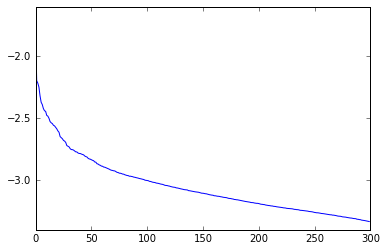

In [79]:
plt.plot(np.log10(svd.explained_variance_ratio_))

In [80]:
U = svd.fit_transform(M_PMI)

In [81]:
U.shape

(15419, 300)

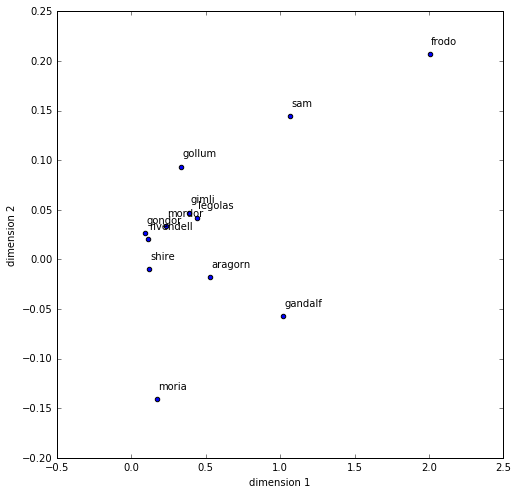

In [97]:
plt.figure(figsize=(8,8))
for word in ["gondor","mordor","sam","frodo","gandalf","gollum","aragorn","shire","moria","legolas","rivendell","gimli"]:
    gondor = U[fixed_word_list.index(word),:2]
    plt.scatter(gondor[0],gondor[1])
    plt.annotate(word,xy=[gondor[0]+.01,gondor[1]+.01])
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")

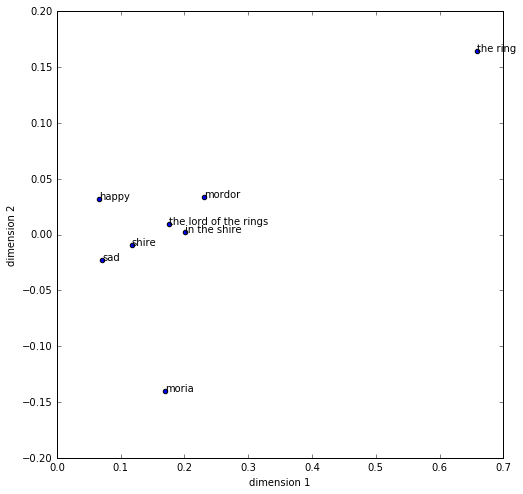

In [105]:
plt.figure(figsize=(8,8))
for word in ["happy","sad","mordor","shire","moria","the ring","in the shire",'the lord of the rings']:
    gondor = U[fixed_word_list.index(word),:2]
    plt.scatter(gondor[0],gondor[1])
    plt.annotate(word,xy=[gondor[0],gondor[1]])
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")

In [84]:
U[fixed_word_list.index("sam"),:2]

array([ 1.06311684,  0.14486732])

In [85]:
U[fixed_word_list.index("frodo"),:2]

array([ 2.00508008,  0.20663159])